In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from concurrent.futures import ThreadPoolExecutor

# Download required NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [2]:
# Read the data (assuming it's in a CSV file)
df = pd.read_csv('../data/raw/hotel_reviews.csv', nrows=10000)

In [3]:
# Create separate rows for positive and negative reviews
def split_reviews(df):
    # Create positive reviews dataframe
    pos_df = df.copy()
    pos_df['review_type'] = 'positive'
    pos_df['review_text'] = pos_df['Positive_Review']
    pos_df['word_count'] = pos_df['Review_Total_Positive_Word_Counts']

    # Create negative reviews dataframe
    neg_df = df.copy()
    neg_df['review_type'] = 'negative'
    neg_df['review_text'] = neg_df['Negative_Review']
    neg_df['word_count'] = neg_df['Review_Total_Negative_Word_Counts']

    # Combine both dataframes
    combined_df = pd.concat([pos_df, neg_df], ignore_index=True)
    
    # Keep only relevant columns
    cols_to_keep = ['Hotel_Name', 'review_type', 'review_text', 'word_count', 
                    'Reviewer_Score', 'Tags']
    combined_df = combined_df[cols_to_keep]
    
    # Remove "No Negative" and "No Positive" reviews
    combined_df = combined_df[~combined_df['review_text'].isin(['No Negative', 'No Positive'])]
    
    return combined_df

# Transform the data
transformed_df = split_reviews(df)

In [4]:
transformed_df.head()

,Hotel_Name,review_type,review_text,word_count,Reviewer_Score,Tags
0,Hotel Arena,positive,Only the park outside of the hotel was beauti...,11,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
1,Hotel Arena,positive,No real complaints the hotel was great great ...,105,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
2,Hotel Arena,positive,Location was good and staff were ok It is cut...,21,7.1,"[' Leisure trip ', ' Family with young childre..."
3,Hotel Arena,positive,Great location in nice surroundings the bar a...,26,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex..."
4,Hotel Arena,positive,Amazing location and building Romantic setting,8,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St..."


In [5]:
nlp = spacy.load('en_core_web_sm')


In [33]:
# Load spacy model for text processing
nlp = spacy.load('en_core_web_sm')

def transform_dataframe(df):
    """Transform the dataframe to separate positive and negative reviews"""
    # Create arrays for the new data
    data = {
        'review_type': ['positive', 'negative'] * len(df),
        'review_text': np.concatenate([df['Positive_Review'].values, df['Negative_Review'].values]),
        'word_count': np.concatenate([df['Review_Total_Positive_Word_Counts'].values, 
                                    df['Review_Total_Negative_Word_Counts'].values]),
        'score': np.repeat(df['Reviewer_Score'].values, 2)
    }
    
    # Create transformed dataframe
    transformed_df = pd.DataFrame(data)
    
    # Drop rows with "No Negative" or "No Positive"
    mask = ~transformed_df['review_text'].isin(['No Negative', 'No Positive'])
    transformed_df = transformed_df[mask].reset_index(drop=True)
    
    return transformed_df

def preprocess_text(text):
    """Preprocess text for aspect extraction"""
    # Convert to lowercase and tokenize
    doc = nlp(text.lower())
    
    # Remove stopwords and punctuation, keep only nouns and adjectives
    tokens = [token.lemma_ for token in doc 
             if not token.is_stop and not token.is_punct 
             and token.pos_ in ['NOUN', 'ADJ']]
    
    return ' '.join(tokens)

def extract_aspects(df, n_clusters=5):
    """Extract aspects using TF-IDF and K-means clustering"""
    # Preprocess reviews using parallel processing
    tqdm.pandas(desc="Preprocessing texts")
    df['processed_text'] = df['review_text'].progress_apply(preprocess_text)
    
    # TF-IDF Vectorization
    print("Performing TF-IDF vectorization...")
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
    
    # K-means clustering
    print("Performing K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
    
    # Get top terms for each cluster
    feature_names = vectorizer.get_feature_names_out()
    cluster_terms = {}
    
    for i in range(n_clusters):
        center = kmeans.cluster_centers_[i]
        top_indices = center.argsort()[-5:][::-1]  # Get top 5 terms
        cluster_terms[i] = [feature_names[idx] for idx in top_indices]
    
    # Add cluster assignments to dataframe
    df['aspect_cluster'] = clusters
    df['aspect_terms'] = df['aspect_cluster'].map(cluster_terms)
    
    return df, cluster_terms, silhouette_avg, tfidf_matrix, kmeans

# def main(input_file):
#     # Read the data
#     print("Reading data...")
#     df = pd.read_csv(input_file)
    
#     # Transform dataframe
#     print("Transforming dataframe...")
#     transformed_df = transform_dataframe(df)
    
#     # Extract aspects
#     print("Extracting aspects...")
#     final_df, cluster_terms, silhouette = extract_aspects(transformed_df)
    
#     return final_df, cluster_terms, silhouette

In [34]:
print("Extracting aspects...")
final_df, cluster_terms, silhouette, tfidf_matrix, kmeans = extract_aspects(transformed_df)

Extracting aspects...


Preprocessing texts: 100%|██████████| 17021/17021 [01:30<00:00, 188.89it/s]


Performing TF-IDF vectorization...
Performing K-means clustering...
Silhouette Score: 0.03308517277686205


In [8]:
# Print cluster terms (aspects)
for cluster, terms in cluster_terms.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

# Sample of final dataframe
print("\nSample of processed data:")
print(final_df[['review_text', 'review_type', 'aspect_cluster', 'aspect_terms']].head())

Cluster 0: good, location, breakfast, staff, room
Cluster 1: location, great, excellent, staff, hotel
Cluster 2: room, hotel, breakfast, bed, great
Cluster 3: staff, friendly, helpful, location, great
Cluster 4: room, small, bathroom, size, bed

Sample of processed data:
                                         review_text review_type  \
0   Only the park outside of the hotel was beauti...    positive   
1   No real complaints the hotel was great great ...    positive   
2   Location was good and staff were ok It is cut...    positive   
3   Great location in nice surroundings the bar a...    positive   
4    Amazing location and building Romantic setting     positive   

   aspect_cluster                              aspect_terms  
0               2      [room, hotel, breakfast, bed, great]  
1               2      [room, hotel, breakfast, bed, great]  
2               0  [good, location, breakfast, staff, room]  
3               2      [room, hotel, breakfast, bed, great]  
4        

In [36]:
final_df.tail()

,Hotel_Name,review_type,review_text,word_count,Reviewer_Score,Tags,processed_text,aspect_cluster,aspect_terms
19992,Grand Royale London Hyde Park,negative,Dirty towels hotel misplaced our baggage Room...,20,4.2,"[' Leisure trip ', ' Couple ', ' Superior Doub...",dirty towel hotel baggage room small advertisi...,4,"[room, small, bathroom, size, bed]"
19993,Grand Royale London Hyde Park,negative,Bed and bedroom too small Breakfast would be ...,13,7.9,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",bed small breakfast nice,4,"[room, small, bathroom, size, bed]"
19996,Grand Royale London Hyde Park,negative,Room size,3,7.9,"[' Leisure trip ', ' Group ', ' Superior Doubl...",room size,4,"[room, small, bathroom, size, bed]"
19997,Grand Royale London Hyde Park,negative,Room very small Very cramped,7,5.8,"[' Leisure trip ', ' Couple ', ' Superior Doub...",room small,4,"[room, small, bathroom, size, bed]"
19999,Grand Royale London Hyde Park,negative,Windows Were broken,5,3.8,"[' Leisure trip ', ' Family with young childre...",window,2,"[room, hotel, breakfast, bed, great]"


In [37]:
from collections import Counter
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
def label_clusters(df, cluster_terms, tfidf_matrix, kmeans):
    """
    Label clusters based on predominant aspects
    """
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tfidf_matrix, kmeans.labels_)
    
    # Define common hotel aspects and their related keywords
    aspect_keywords = {
        'room': ['room', 'bed', 'bathroom', 'shower', 'furniture', 'clean'],
        'staff': ['staff', 'service', 'reception', 'employee', 'helpful'],
        'location': ['location', 'central', 'distance', 'transport', 'nearby'],
        'food': ['breakfast', 'restaurant', 'food', 'meal', 'dining'],
        'facilities': ['pool', 'gym', 'wifi', 'internet', 'parking']
    }

    aspect_labels = {}
    
    # For each cluster
    for cluster_id in range(kmeans.n_clusters):
        # Get all reviews in this cluster
        cluster_mask = kmeans.labels_ == cluster_id
        cluster_reviews = df[cluster_mask]['processed_text']
        
        # Count word frequencies in the cluster
        term_counts = Counter(' '.join(cluster_reviews).split())
        
        # Score each aspect based on keyword matches
        aspect_scores = {}
        for aspect, keywords in aspect_keywords.items():
            score = sum(term_counts.get(keyword, 0) for keyword in keywords)
            aspect_scores[aspect] = score
        
        # Get the predominant aspect
        predominant_aspect = max(aspect_scores.items(), key=lambda x: x[1])[0]
        
        # Store cluster information
        aspect_labels[cluster_id] = {
            'predominant_aspect': predominant_aspect,
            'top_terms': cluster_terms[cluster_id],
            'avg_silhouette': np.mean(sample_silhouette_values[cluster_mask])
        }
    
    return aspect_labels

In [48]:
def evaluate_clustering(df, tfidf_matrix, kmeans, aspect_labels):
    """
    Evaluate clustering performance and return metrics
    """
    # Overall silhouette score
    overall_score = silhouette_score(tfidf_matrix, kmeans.labels_)
    
    # Calculate silhouette score for each sample
    sample_silhouette_values = silhouette_samples(tfidf_matrix, kmeans.labels_)
    
    # Cluster sizes
    cluster_sizes = df['aspect_cluster'].value_counts().to_dict()
    
    # Calculate metrics per cluster
    cluster_metrics = {}
    for cluster_id in range(kmeans.n_clusters):
        cluster_mask = kmeans.labels_ == cluster_id
        cluster_metrics[cluster_id] = {
            'size': cluster_sizes.get(cluster_id, 0),
            'avg_silhouette': np.mean(sample_silhouette_values[cluster_mask]),
            'std_silhouette': np.std(sample_silhouette_values[cluster_mask]),
            'predominant_aspect': aspect_labels[cluster_id]['predominant_aspect'],
            'top_terms': aspect_labels[cluster_id]['top_terms']
        }
    
    evaluation_results = {
        'overall_silhouette_score': overall_score,
        'cluster_sizes': cluster_sizes,
        'cluster_metrics': cluster_metrics,
        'sample_silhouette_values': sample_silhouette_values
    }
    
    return evaluation_results

In [53]:
def plot_clustering_evaluation(df, evaluation_results):
    """
    Generate visualization plots for clustering evaluation
    """
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Silhouette scores by aspect
    plt.subplot(1, 3, 1)
    aspects = [metrics['predominant_aspect'] for metrics in evaluation_results['cluster_metrics'].values()]
    scores = [metrics['avg_silhouette'] for metrics in evaluation_results['cluster_metrics'].values()]
    
    sns.barplot(x=aspects, y=scores)
    plt.title('Average Silhouette Score by Aspect')
    plt.xticks(rotation=45)
    
    # Plot 2: Cluster sizes
    plt.subplot(1, 3, 2)
    sizes = [metrics['size'] for metrics in evaluation_results['cluster_metrics'].values()]
    sns.barplot(x=aspects, y=sizes)
    plt.title('Number of Reviews per Aspect')
    plt.xticks(rotation=45)
    
    # Plot 3: Silhouette plot
    plt.subplot(1, 3, 3)
    y_lower = 10
    for cluster_id, metrics in evaluation_results['cluster_metrics'].items():
        cluster_silhouette_values = evaluation_results['sample_silhouette_values'][df['aspect_cluster'] == cluster_id]
        cluster_silhouette_values.sort()
        size_cluster = len(cluster_silhouette_values)
        y_upper = y_lower + size_cluster
        
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_values,
                         alpha=0.7)
        y_lower = y_upper + 10

    plt.title('Silhouette Plot')
    plt.xlabel('Silhouette coefficient')
    plt.ylabel('Cluster label')
    
    plt.tight_layout()
    return fig

In [54]:
def print_cluster_analysis(evaluation_results):
    """
    Print detailed analysis of clustering results
    """
    print("\nClustering Analysis Results:")
    print(f"Overall Silhouette Score: {evaluation_results['overall_silhouette_score']:.3f}")
    
    print("\nCluster Details:")
    for cluster_id, metrics in evaluation_results['cluster_metrics'].items():
        print(f"\nCluster {cluster_id}:")
        print(f"Aspect: {metrics['predominant_aspect']}")
        print(f"Top Terms: {', '.join(metrics['top_terms'])}")
        print(f"Size: {metrics['size']} reviews")
        print(f"Average Silhouette Score: {metrics['avg_silhouette']:.3f}")
        print(f"Silhouette Score Std: {metrics['std_silhouette']:.3f}")
    
    # Additional statistics
    print("\nSummary Statistics:")
    print(f"Total number of reviews: {sum(evaluation_results['cluster_sizes'].values())}")
    print(f"Number of clusters: {len(evaluation_results['cluster_metrics'])}")
    print("\nAspect Distribution:")
    for cluster_id, metrics in evaluation_results['cluster_metrics'].items():
        percentage = (metrics['size'] / sum(evaluation_results['cluster_sizes'].values())) * 100
        print(f"{metrics['predominant_aspect']}: {percentage:.1f}%")

Labeling clusters and evaluating performance...
Evaluating clustering performance...
Generating visualization plots...

Clustering Analysis Results:
Overall Silhouette Score: 0.033

Cluster Details:

Cluster 0:
Aspect: location
Top Terms: good, location, breakfast, staff, room
Size: 1324 reviews
Average Silhouette Score: 0.041
Silhouette Score Std: 0.054

Cluster 1:
Aspect: location
Top Terms: location, great, excellent, staff, hotel
Size: 793 reviews
Average Silhouette Score: 0.326
Silhouette Score Std: 0.176

Cluster 2:
Aspect: room
Top Terms: room, hotel, breakfast, bed, great
Size: 10851 reviews
Average Silhouette Score: 0.005
Silhouette Score Std: 0.033

Cluster 3:
Aspect: staff
Top Terms: staff, friendly, helpful, location, great
Size: 2090 reviews
Average Silhouette Score: 0.041
Silhouette Score Std: 0.060

Cluster 4:
Aspect: room
Top Terms: room, small, bathroom, size, bed
Size: 1963 reviews
Average Silhouette Score: 0.057
Silhouette Score Std: 0.051

Summary Statistics:
Total 

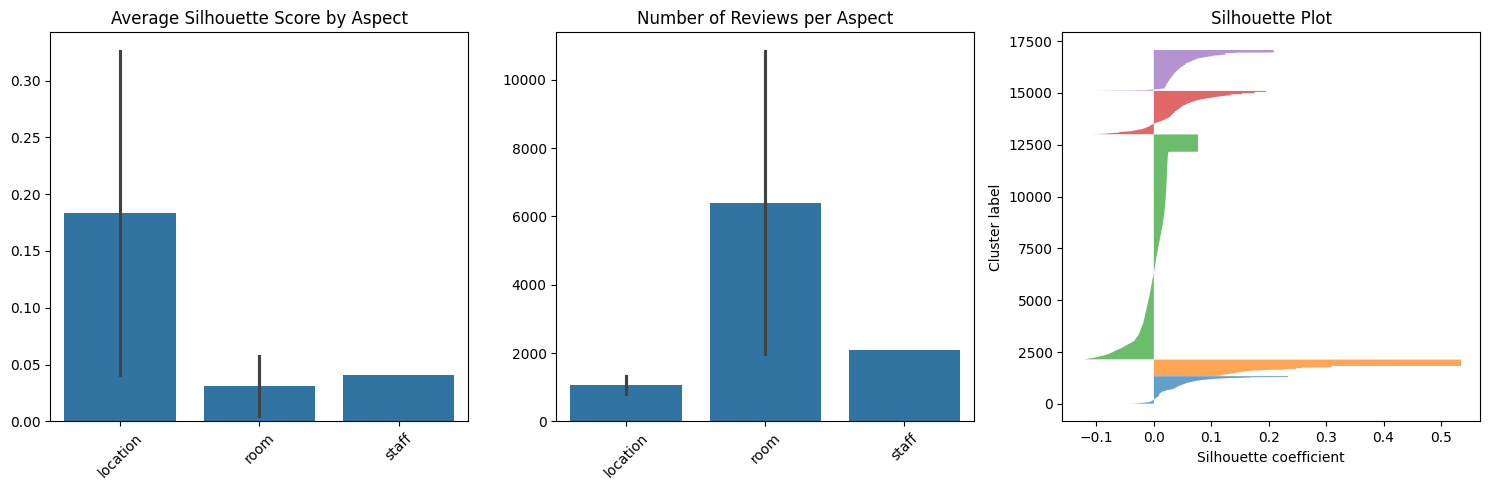

In [55]:
# Label clusters and evaluate
print("Labeling clusters and evaluating performance...")
aspect_labels = label_clusters(transformed_df, cluster_terms, tfidf_matrix, kmeans)

# Evaluate clustering
print("Evaluating clustering performance...")
evaluation_results = evaluate_clustering(transformed_df, tfidf_matrix, kmeans, aspect_labels)

# Generate plots
print("Generating visualization plots...")
evaluation_plot = plot_clustering_evaluation(transformed_df, evaluation_results)

# Print analysis
print_cluster_analysis(evaluation_results)

# Add aspect labels to dataframe
transformed_df['aspect_label'] = transformed_df['aspect_cluster'].map(
    lambda x: aspect_labels[x]['predominant_aspect']
)

In [57]:
transformed_df.to_csv('../data/processed/hotel_reviews_aspects.csv', index=False)

In [56]:
print(transformed_df)

                          Hotel_Name review_type  \
0                        Hotel Arena    positive   
1                        Hotel Arena    positive   
2                        Hotel Arena    positive   
3                        Hotel Arena    positive   
4                        Hotel Arena    positive   
...                              ...         ...   
19992  Grand Royale London Hyde Park    negative   
19993  Grand Royale London Hyde Park    negative   
19996  Grand Royale London Hyde Park    negative   
19997  Grand Royale London Hyde Park    negative   
19999  Grand Royale London Hyde Park    negative   

                                             review_text  word_count  \
0       Only the park outside of the hotel was beauti...          11   
1       No real complaints the hotel was great great ...         105   
2       Location was good and staff were ok It is cut...          21   
3       Great location in nice surroundings the bar a...          26   
4        Amazin